In [1]:
import pints
import pints.toy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

import numpy as np
import matplotlib.pyplot as plt
import GPy
from GPy import kern as kern

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import string
from itertools import product

## Specifying model

In [2]:
# Load problem from predefined ones
model = emupints.Problems.FitzhughNagumoModelDiscontinious
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([[-0.83769168,  0.8952975 ],
       [-0.94110044,  1.07819729],
       [-0.49877221,  1.10011622],
       [-0.65657056,  1.09315452],
       [-0.67545577,  0.94807061]])

In [3]:
# take required variables for visualisation
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
log_prior = problem['log_prior']
log_posterior = problem['log_posterior']
real_parameters = problem['parameters']
pints_problem = problem['problem']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

print(real_parameters)

[0.1 0.5 3. ]


## Creating emulator and specifying variables

In [4]:
# training size
training_size = 1000

input_parameters = log_prior.sample(training_size)
target_likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)

emu = emupints.GPEmulator(log_likelihood, 
                          input_parameters, 
                          target_likelihoods,) 
                          #input_scaler=StandardScaler())

## Kernel selection

In [5]:
n_parameters = emu.n_parameters()

kernels = [
    kern.Linear(n_parameters),
    kern.RBF(n_parameters),
    kern.RatQuad(n_parameters),
    kern.MLP(n_parameters),
    kern.Matern52(n_parameters),
    kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
    kern.Matern52(n_parameters) + kern.RBF(n_parameters),
    kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
    kern.MLP(n_parameters) + kern.Matern52(n_parameters) + kern.RatQuad(n_parameters),
]

kernel_names = [
    'Linear',
    'RBF',
    'RatQuad',
    'MLP',
    'Matern',
    'RatQuad + RBF*RBF',
    'Matern52 + RBF * RBF',
    'RatQuad + RBF * RBF',
    'MLP + Matern + RatQuad'
]

# kernels that have been optimized for input data
trained_kernels = []

# possible optimizers: 
# ‘scg’, ‘lbfgs’, ‘tnc’
# can specify max number of iterations using max_iters
optimizer = "lbfgs"
max_iters = 500
emu.set_parameters(optimizer = optimizer)

In [6]:
# when the output data is normalized values of variance should be small
# hence ignore any kernel that has a subkernel 
# (i.e kernel that is a part of sum/product) 
# with variance > 1000
# set avoid_overfitting to False to stop this effect
avoid_overfitting = False
variance_threshold = 1000

# store prediction time for comparison
likelihood_time = %timeit -o log_likelihood(real_parameters)
likelihood_time = likelihood_time.average

4.18 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
marginal_likelihoods = []
prediction_times = []

for kernel, kernel_name in zip(kernels, kernel_names):
    emu.set_parameters(kernel = kernel)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = max_iters, messages = False)

    trained_kernel = emu.get_trained_kern()
    trained_kernels.append(trained_kernel)

    # time prediction
    emu_time =  %timeit -o emu(real_parameters)
    prediction_times.append(emu_time.average)

    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(kernel_name, ml))

965 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Linear: -1237.41
628 µs ± 52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RBF: -144.55
697 µs ± 54.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad: -99.88
727 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MLP: -35.71
661 µs ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Matern: -104.57
995 µs ± 126 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad + RBF*RBF: -93.96
814 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Matern52 + RBF * RBF: -93.65
832 µs ± 4.93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad + RBF * RBF: -93.96
1.16 ms ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MLP + Matern + RatQuad: -90.55


In [8]:
best_kernel = None
best_score = -1 << 31
best_time = -1 << 31

# find kernel with highest log marginal likelihood
for kernel, score, emu_time in zip(trained_kernels, marginal_likelihoods, prediction_times):
    # ignore any overfitting kernel
    if avoid_overfitting and emutils.has_high_variance(kernel, threshold = variance_threshold):
        continue
    # avoid kernels that don't provide 5x speed up
    if 5 * emu_time > likelihood_time:
        continue

    if score > best_score:
        best_kernel = kernel
        best_time = emu_time
        best_score = best_score
        
print('Prediction time: ', best_time)
best_kernel

Prediction time:  0.0008315112244204751


sum.,value,constraints,priors
RatQuad.variance,0.24150951670313753,+ve,
RatQuad.lengthscale,0.12148088564310236,+ve,
RatQuad.power,0.4904359389142478,+ve,
rbf.variance,0.6583537783689805,+ve,
rbf.lengthscale,0.3790690377048755,+ve,


In [9]:
# TODO: directly assign kernel to GP in class
emu.set_parameters(kernel = kernels[2])
emu.fit(optimize = False, normalizer = True)
emu.optimize(max_iters = max_iters, messages = True)    

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s26  007   1.286887e+02   4.342816e+04 
    03s59  020   9.987840e+01   6.327670e-08 
Runtime:     03s59
Optimization status: Converged



In [10]:
emu.get_gp()

GP_regression.,value,constraints,priors
RatQuad.variance,3.1135094910795873,+ve,
RatQuad.lengthscale,0.15073488847386382,+ve,
RatQuad.power,0.0756757156294771,+ve,
Gaussian_noise.variance,0.027007405640865893,+ve,


In [11]:
if n_parameters == 2:
    # generate data for surfaces
    test_splits = 20 # number of splits along each axis
    r_grid, k_grid, test_data = emutils.generate_grid(bounds.lower(), 
                                                      bounds.upper(), 
                                                      test_splits)    

    emu_grid = emutils.predict_grid(emu, test_data)
    real_grid = emutils.predict_grid(log_likelihood, test_data)

    plt.figure(figsize = (10, 5))
    ax = emuplt.surface(r_grid, k_grid, emu_grid, 
                        title = "True log_likelihood",
                        alpha = 0.8,
                        cmap="Blues",
                        x_label = "r (growth rate)",
                        y_label = "k (carrying capacity)"
                       )

    ax.plot_surface(r_grid, k_grid, real_grid, cmap="Reds", alpha = .5)

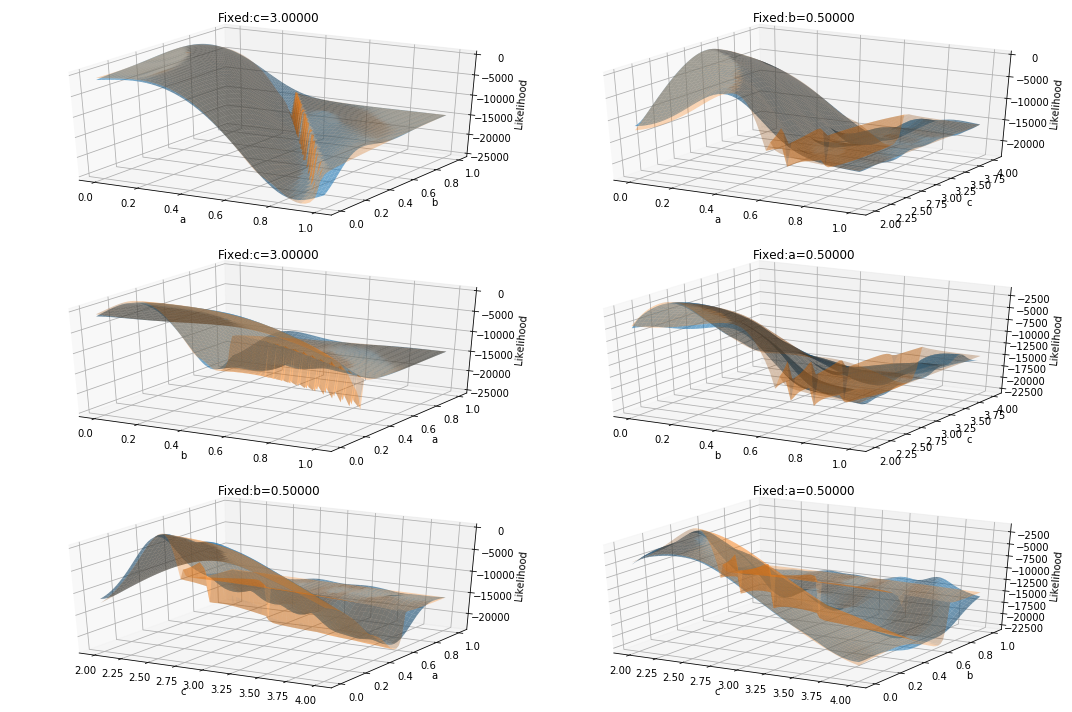

In [12]:
if n_parameters >= 3:
    fixed_parameters = emutils.fix_parameters(bounds)

    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        shape = (n_parameters, n_parameters - 1),
        contour = False,
        additional_log_likelihoods = [log_likelihood]
    )
    
    plt.show(fig)

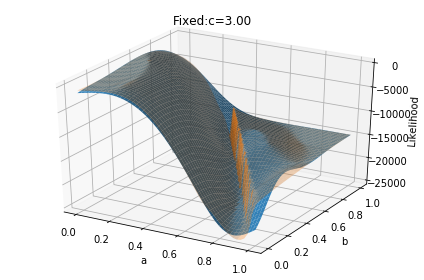

In [36]:
fig, ax = emuplt.plot_surface_fixed_param(
    emu,
    bounds,
    fixed=[(2, 3)],
    contour=False,
    index_to_param_name=index_to_param_name,
    precision=2,
    additional_log_likelihoods=[log_likelihood],
)


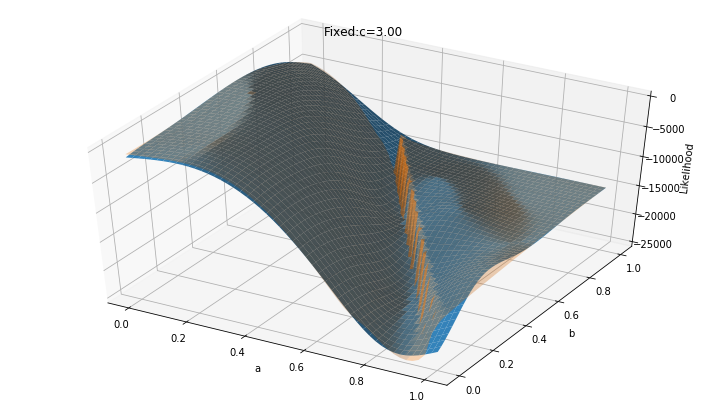

In [52]:
ax.view_init(45, 30 + 90 * 3)
fig.set_size_inches(10.5, 6)
fig

## Running and Timing MCMC

In [15]:
test_X = bounds.sample(500)
test_y = np.apply_along_axis(log_likelihood, 1, test_X)

pred_y = np.apply_along_axis(emu, 1, test_X)

emumet.mape(test_y, pred_y)

5.746466398265889

In [16]:
# for Logistic and Lotka-Voltera use default
mcmc_method = None # Adaptive covariance by default
# mcmc_method = pints.PopulationMCMC
# mcmc_method = pints.MetropolisRandomWalkMCMC
# mcmc_method = pints.DifferentialEvolutionMCMC

# MCMC parameters
num_chains = 3
max_iters = 20000

In [17]:
emu_posterior = pints.LogPosterior(emu, log_prior)
real_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [18]:
# CMA-es
score = pints.SumOfSquaresError(pints_problem)
x0 = bounds.sample(1)[0]

found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      672.3809   0:00.1
1     14     672.3809   0:00.1
2     21     607.6529   0:00.1
3     28     607.6529   0:00.1
20    147    10.98357   0:00.6
40    287    8.293171   0:01.2
60    427    7.897213   0:01.8
80    567    7.89681    0:02.4
100   707    7.89681    0:03.0
120   847    7.89681    0:03.6
140   987    7.89681    0:04.3
160   1127   7.89681    0:04.9
180   1267   7.89681    0:05.5
200   1407   7.89681    0:06.1
220   1547   7.89681    0:06.8
240   1687   7.89681    0:07.4
260   1827   7.89681    0:08.0
280   1967   7.89681    0:08.7
300   2107   7.89681    0:09.3
310   2170   7.89681    0:09.6
Halting: No significant change for 200 iterations.


In [19]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

[array([0.09534049, 0.46664891, 3.03537964]),
 array([0.09629389, 0.4713154 , 3.06573344]),
 array([0.09438708, 0.46198242, 3.00502585])]

In [20]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, 
                              num_chains, 
                              xs, 
                              method = mcmc_method, 
                             )
emu_mcmc.set_max_iterations(max_iters)
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 56.7 s, sys: 208 ms, total: 56.9 s
Wall time: 57.1 s


In [21]:
%%time
# population MCMC
real_mcmc = pints.MCMCSampling(real_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                              )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...


KeyboardInterrupt: 

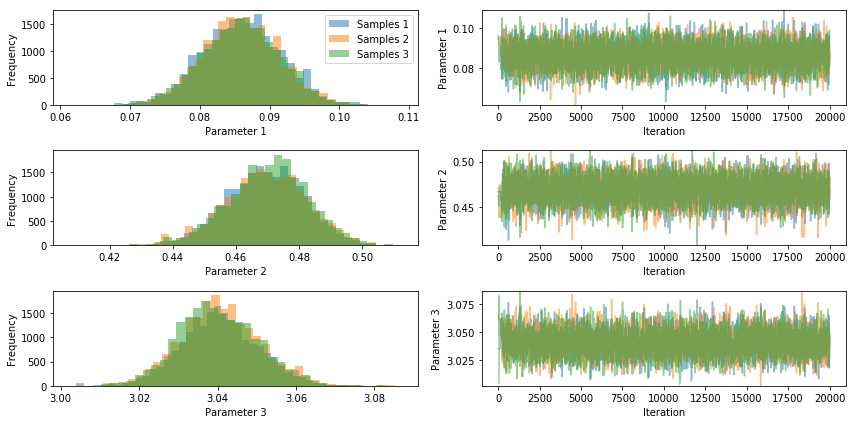

In [22]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

In [23]:
pints.plot.trace(real_chains)
plt.show()

NameError: name 'real_chains' is not defined

In [ ]:
# Look at likelihood changes along one chain
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
real_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()

print(emumet)

In [ ]:
iters = range(len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color="Red", label='emu')
plt.plot(iters, real_prediction, color="Blue", label='model')
plt.legend()
plt.show()

In [ ]:
diffs = np.abs(emu_prediction - real_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood difference")
plt.plot(iters, diffs, color = "Black")
plt.show()